In [5]:
import os
import shutil
import glob
import numpy as np
import rasterio 
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import pandas as pd
from datetime import datetime

In [6]:
folder_dir=r'C:\Users\SANTOSH.SUBEDI\practice\McCook\automation'
Event_Date='2022-07-05'
Threshold=0.1
Corn_Only=r'C:\Users\SANTOSH.SUBEDI\Downloads\Damage_distribution_map7.tif'
aoi= 'C:/Users/SANTOSH.SUBEDI/practice/McCook/McCook/McCook_reproject.shp'


In [10]:
def rearrange(folder_path):
    all_files = os.listdir(folder_path)
    file_dict = {}
    for filename in all_files:
        if "v2" in filename:
            shared_name = filename.split("v2")[0] + "v2"
            file_dict.setdefault(shared_name, []).append(filename)
    for shared_name, files in file_dict.items():
        target_directory = os.path.join(folder_path, shared_name)
        os.makedirs(target_directory, exist_ok=True)
        for filename in files:
            source_file = os.path.join(folder_path, filename)
            shutil.move(source_file, os.path.join(target_directory, filename))


def indices_calculation(red_band_path, nir_band_path, blue_band_path,goodQuality,Fmask_clipped,shpfile):
    with rasterio.open(red_band_path) as red_src, rasterio.open(nir_band_path) as nir_src, rasterio.open(blue_band_path) as blue_src:
        # Load shapefile
        shp_gdf = gpd.read_file(shpfile)
        geometry = shp_gdf.geometry.iloc[0]
    
        # Perform masking on each band using the respective dataset
        red_clipped, clipped_transform = mask(red_src, [geometry], crop=True)
        nir_clipped, clipped_transform = mask(nir_src, [geometry], crop=True)
        blue_clipped, clipped_transform = mask(blue_src, [geometry], crop=True)
    
        red_clipped = red_clipped.astype(np.float32)
        nir_clipped = nir_clipped.astype(np.float32)
        blue_clipped = blue_clipped.astype(np.float32)

       
        red_assigned_nan = np.where(red_clipped == -9999, np.nan, red_clipped)
        nir_assigned_nan = np.where(nir_clipped == -9999, np.nan, nir_clipped)
        blue_assigned_nan = np.where(blue_clipped == -9999, np.nan, blue_clipped)
        
        red_scaled = red_assigned_nan*0.0001
        nir_scaled = nir_assigned_nan*0.0001
        blue_scaled = blue_assigned_nan*0.0001
        
        evi = 2.5*(nir_scaled - red_scaled)/(nir_scaled + 6.0*red_scaled - 7.5*blue_scaled + 1.0)
        band_masked_evi = np.ma.MaskedArray(evi, np.in1d(Fmask_clipped, goodQuality, invert = True))
        evi = np.ma.filled(band_masked_evi, np.nan)  
    return evi


def band_path_read(folder_path,shp_file):
    folder_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    for folder_name in folder_names:
        folder_path_full=os.path.join(folder_path, folder_name)
        if folder_name.startswith("HLS.L"):
            files_in_folder=os.listdir(folder_path_full)
            red_band_file=[file for file in files_in_folder if 'B04' in file][0]
            red_band_path = os.path.join(folder_path_full,red_band_file)
            green_band_file=[file for file in files_in_folder if 'B03' in file][0]
            green_band_path = os.path.join(folder_path_full,green_band_file)
            swir1_band_file=[file for file in files_in_folder if 'B06' in file][0]
            swir1_band_path = os.path.join(folder_path_full,swir1_band_file)
            swir2_band_file=[file for file in files_in_folder if 'B07' in file][0]
            swir2_band_path = os.path.join(folder_path_full,swir2_band_file)
            nir_band_file=[file for file in files_in_folder if 'B05' in file][0]
            nir_band_path = os.path.join(folder_path_full,nir_band_file)
            blue_band_file=[file for file in files_in_folder if 'B02' in file][0]
            blue_band_path = os.path.join(folder_path_full, blue_band_file)
            mask_band_file=[file for file in files_in_folder if 'Fmask' in file][0]
            mask_band_path = os.path.join(folder_path_full, mask_band_file)
        elif folder_name.startswith("HLS.S"):
            files_in_folder=os.listdir(folder_path_full)
            red_band_file=[file for file in files_in_folder if 'B04' in file][0]
            red_band_path = os.path.join(folder_path_full,red_band_file)
            green_band_file=[file for file in files_in_folder if 'B03' in file][0]
            green_band_path = os.path.join(folder_path_full,green_band_file)
            red_edge1_band_file=[file for file in files_in_folder if 'B05' in file][0]
            red_edge1_band_path = os.path.join(folder_path_full,red_edge1_band_file)
            red_edge2_band_file=[file for file in files_in_folder if 'B06' in file][0]
            red_edge2_band_path = os.path.join(folder_path_full,red_edge2_band_file)
            red_edge3_band_file=[file for file in files_in_folder if 'B07' in file][0]
            red_edge3_band_path = os.path.join(folder_path_full,red_edge3_band_file)
            nir_band_file=[file for file in files_in_folder if 'B08' in file][0]
            nir_band_path = os.path.join(folder_path_full,nir_band_file)
            nir_narrow_band_file=[file for file in files_in_folder if 'B8A' in file][0]
            nir_narrow_band_path = os.path.join(folder_path_full,nir_narrow_band_file)
            swir1_band_file=[file for file in files_in_folder if 'B11' in file][0]
            swir1_band_path = os.path.join(folder_path_full,swir1_band_file)
            swir2_band_file=[file for file in files_in_folder if 'B12' in file][0]
            swir2_band_path = os.path.join(folder_path_full,swir2_band_file)
            blue_band_file=[file for file in files_in_folder if 'B02' in file][0]
            blue_band_path = os.path.join(folder_path_full, blue_band_file)
            mask_band_file=[file for file in files_in_folder if 'Fmask' in file][0]
            mask_band_path = os.path.join(folder_path_full, mask_band_file)
           
        profile=rasterio.open(mask_band_path).profile
        with rasterio.open(mask_band_path) as Fmask_dataset:
            shp_gdf = gpd.read_file(shp_file)
            geometry = shp_gdf.geometry.iloc[0]
            Fmask_clipped, clipped_transform = mask(Fmask_dataset, [geometry], crop=True)
        bitword_order = (1, 1, 1, 1, 1, 1, 2)
        #define number of bitsword based on your input above
        num_bitwords = len(bitword_order)
        total_bits = sum(bitword_order)   # Should be 8, 16, or 32 depending on datatype
        #creates a list of unique value that need to be converted into binary and decoded
        Unique_val_Fmask = list(np.unique(Fmask_clipped))
        goodQuality = []
        for j in Unique_val_Fmask:
            i= 0
            all_bits = []
            bits = total_bits
            binary = format(j, 'b').zfill(total_bits)
            all_bits.append(str(j) + '=' + str(binary)) 
            for b in bitword_order:
                Prev_bits = bits
                bits = bits - b
                i = i + 1
                if i == 1:
                    bitword = binary[bits:]
                    #print('Bit Word'  + str(i) + ':' + str(bitword))
                    all_bits.append('Bit Word'  + str(i) + ':' + str(bitword))
                elif i == num_bitwords:
                    bitword = binary[:Prev_bits]
                     #print('Bit Word' + str(i) + ':' + str(bitword))
                    all_bits.append('Bit Word'  + str(i) + ':' + str(bitword))
                else:
                    bitword = binary [bits:Prev_bits]
                     #print('Bit Word' + str(i) + ':' + str(bitword))
                    all_bits.append('Bit Word'  + str(i) + ':' + str(bitword))
        
            if int(all_bits[2].split(':')[-1]) == 0 + int(all_bits[4].split(':')[-1]) == 0:
                goodQuality.append(j)
        if os.path.exists(red_band_path) and os.path.exists(nir_band_path) and os.path.exists(blue_band_path):
            evi = indices_calculation(red_band_path, nir_band_path, blue_band_path,goodQuality,Fmask_clipped,aoi)
            print(evi.shape)
            nodata_value=-9999
            profile.update(nodata=nodata_value,dtype=rasterio.float32)
            profile.update({
                'height': evi.shape[1],
                'width' : evi.shape[2]
            })
            output_path = os.path.join(folder_path, f'{folder_name}.tif')
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(evi[0],1)

def rename(folder_path):
    all_items = os.listdir(folder_path)
    tif_files= [items for items in all_items if items.endswith('.tif')]
    for filename in tif_files:
        match = re.search(r'\d{7}', filename)
        if match:
            new_name = match.group(0)  
            new_path = os.path.join(folder_path, f'{new_name}.tif')
            if os.path.exists(new_path):
                continue
            else:                
                os.rename(os.path.join(folder_path, filename), new_path)
                print(f"File renamed to: {new_path}")
            
def stack_for_evi(dirpath):
    search_criteria=f'*.tif'
    q = os.path.join(dirpath, search_criteria)
    print(q)
    all_tif_files = glob.glob(q)
    regex_pattern = r'\b\d{7}\.tif\b'
    Im_fps = [f for f in all_tif_files if re.search(regex_pattern, os.path.basename(f))]

    print("Filtered file paths:", Im_fps)
    print(Im_fps)
    stk = []
    for j in Im_fps:
        with rasterio.open(j) as src:
            data = src.read(1)  
            stk.append(data)
            print(data.shape)
    stacked_evi = np.stack(stk, axis=0)
    print(stacked_evi.shape)
    return stacked_evi

def pre_post_event(event_date,folder_path):
    all_files=os.listdir(folder_path)
    date_obj=datetime.strptime(event_date, "%Y-%m-%d")
    year = date_obj.year
    day_of_year = date_obj.timetuple().tm_yday
    desired_format = f"{year}{day_of_year:03d}"
    input_julian_date_int= int(desired_format)
    nearest_files = []
    for i in range(input_julian_date_int-1, 0, -1):
        file_name = f'{i}.tif'
        if file_name in all_files:
            nearest_files.append(file_name) 
            break
    for i in range(input_julian_date_int + 1, input_julian_date_int + 1000): 
        file_name = f'{i}.tif'
        if file_name in all_files:
            nearest_files.append(file_name)  
            break
    return nearest_files
    
def threshold_selection(pre_post_list,folder_path,threshold_value):
    pre_event_file, post_event_file = pre_post_list
    with rasterio.open(os.path.join(folder_path, pre_event_file)) as src:
        pre_event_data = src.read(1)
        print(pre_event_data.shape)
    with rasterio.open(os.path.join(folder_path, post_event_file)) as src:
        post_event_data = src.read(1)
        print(post_event_data.shape)
    
    difference=abs((post_event_data-pre_event_data)/(post_event_data+pre_event_data))
    threshold_classification=np.where(difference<threshold_value,1,2)
    print(threshold_classification.shape)
    return threshold_classification

def output(stacked_evi,threshold_classification,corn_only_raster):
    corn_raster=rasterio.open(corn_only_raster).read(1)
    corn_mask=(corn_raster==1)|(corn_raster==2)
    corn_only=np.where(corn_mask,threshold_classification,0)
    damaged_pixels=np.where(corn_only==1)
    damaged=stacked_evi[:,damaged_pixels[0],damaged_pixels[1]]
    non_damaged_pixels=np.where(corn_only==2)
    not_damaged=stacked_evi[:,non_damaged_pixels[0],non_damaged_pixels[1]]
    nt_dmg=not_damaged.T
    dmg=damaged.T
    random_dmg=np.random.choice(dmg.shape[0],size=500,replace=False)
    dmg_data=dmg[random_dmg]
    random_nt_dmg=np.random.choice(nt_dmg.shape[0],size=500,replace=False)
    nt_dmg_data=nt_dmg[random_nt_dmg]
    cmap=ListedColormap(['red','green'])
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Damaged', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Non-Damaged', markerfacecolor='green', markersize=10)
    ]
    #damage map of whole county
    plt.figure(figsize=(9,7))
    plt.imshow(threshold_classification,cmap=cmap,interpolation='nearest')
    plt.title('Thresholded EVI Difference')
    plt.legend(handles=legend_elements, loc='lower right')
    plt.show()
    cmap=ListedColormap(['none','red','green'])
    
    #damage map of corn field of whole county
    plt.figure(figsize=(9,7))
    plt.imshow(corn_only,cmap=cmap,interpolation='nearest')
    plt.title('Classified Corn Fields')
    plt.legend(handles=legend_elements, loc='upper right')
    plt.show()
    plt.figure(figsize=(16, 6))  
    plt.subplot(1, 2, 1) 
    for i in range(300, 500):
        plt.plot(dmg_data[i, :], alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('EVI Value')
    plt.title('Time Series of Damaged Field Pixels')
    hail_event_date = 10
    plt.axvline(x=hail_event_date, color='k', linestyle='--', label='Hail Event Date')
    plt.ylim(0, 1)
    plt.legend()
    
    plt.subplot(1, 2, 2) 
    for i in range(250, 400):
        plt.plot(nt_dmg_data[i, :], alpha=0.5)
    plt.xlabel('Time')
    plt.ylabel('EVI Value')
    plt.title('Time Series of Not Damaged Field Pixels')
    plt.axvline(x=hail_event_date, color='k', linestyle='--', label='Hail Event Date')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()

    plt.show()

    



(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
(1, 1315, 1314)
File renamed to: C:\Users\SANTOSH.SUBEDI\practice\McCook\automation\2022130.tif
File renamed to: C:\Users\SANTOSH.SUBEDI\practice\McCook\automation\2022138.tif
File renamed to: C:\Users\SANTOSH.SUBEDI\practice\McCook\automation\2022170.tif
File renamed to: C:\Users\SANTOSH.SUBEDI\practice\McCook\automation\2022178.tif
File renamed to: C:\Users\SANTOSH.SUBEDI\practice\McCook\automation\2022186.tif
File renamed to: C:\Users\SANTOSH.SUBEDI\practice\McCook\automation\2022194.tif
File renamed to: C:\Users\SANTOSH.SUBEDI\practice\McCook\automation\2022

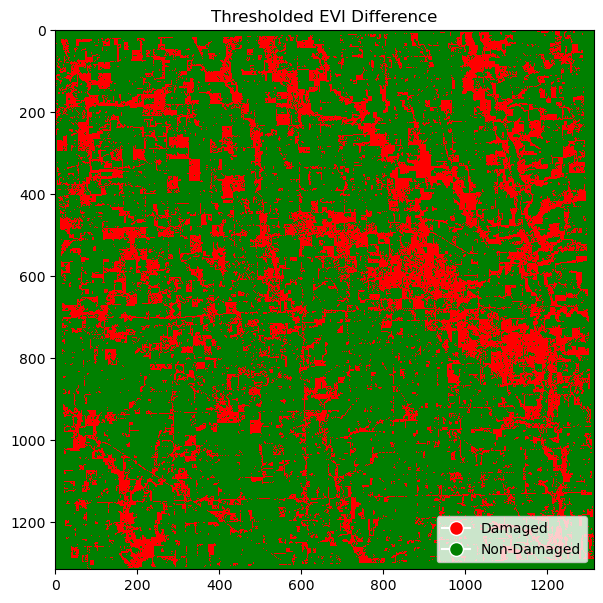

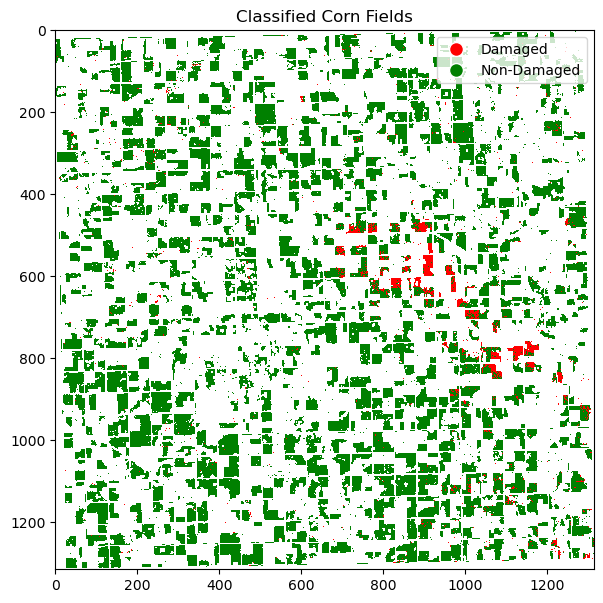

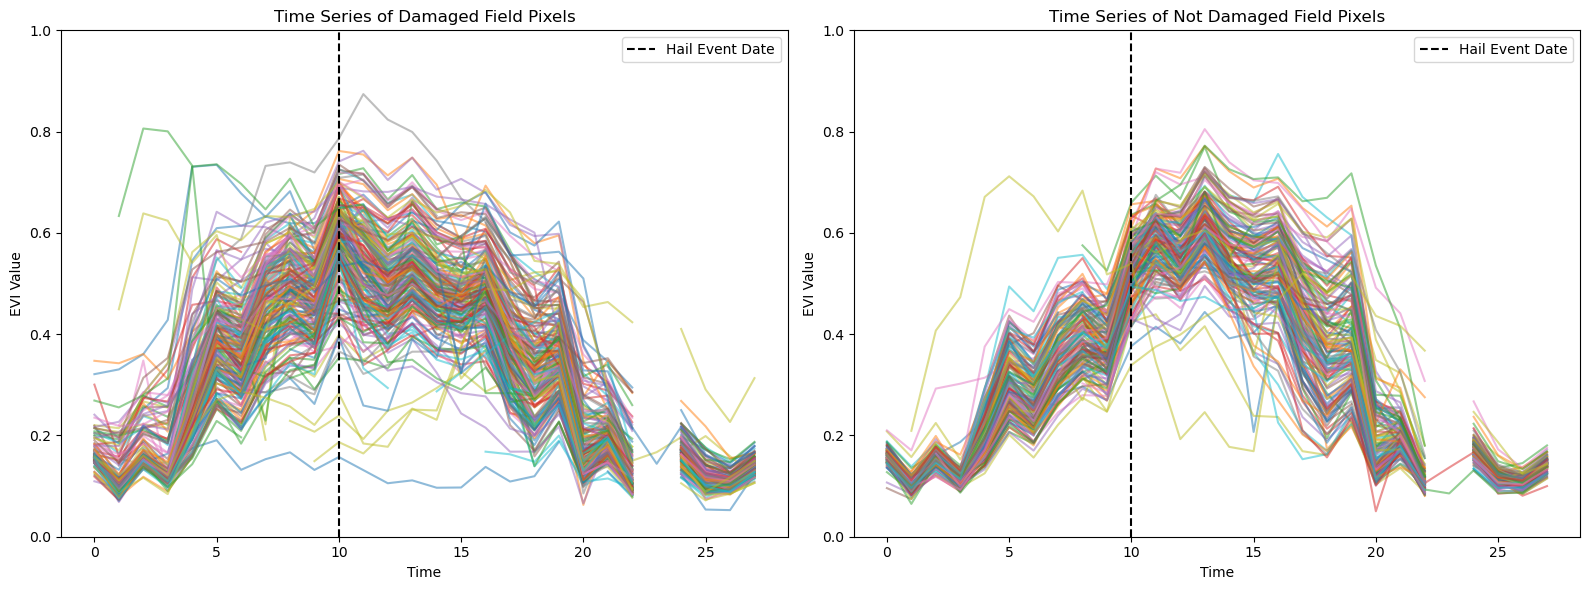

In [11]:
rearrange(folder_dir)
band_path_read(folder_dir,aoi)
rename(folder_dir)
stacked_evi=stack_for_evi(folder_dir)
pre_post_list=pre_post_event(Event_Date,folder_dir)
threshold_classification=threshold_selection(pre_post_list, folder_dir,Threshold)
output(stacked_evi,threshold_classification,Corn_Only)